In [2]:
import os
from io import BytesIO
import numpy as np
from PIL import Image
import tensorflow as tf
import sys
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
class JaNetModel(object):

    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    def __init__(self, tarball_path):
       
        self.graph = tf.Graph()

        graph_def = None
        graph_def = tf.GraphDef.FromString(open("inference_graph/frozen_inference_graph.pb", "rb").read()) 

        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')

        self.sess = tf.Session(graph=self.graph)

    def run(self, image):
        
        width, height = image.size
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        
        batch_seg_map = self.sess.run(self.OUTPUT_TENSOR_NAME,
           feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        
        seg_map = batch_seg_map[0]

        return resized_image, seg_map

def Segmentation(resized_img, seg_img, output_name):
    width, height = resized_img.size
    my_img = np.zeros([height, width, 4], dtype=np.uint8)
    for x in range(width):
        for y in range(height):
            color = seg_img[y,x]
            (r,g,b) = resized_img.getpixel((x,y))
            if color == 0:
                my_img[y,x,3] = 0
            else :
                my_img[y,x] = [r,g,b,255]
    img = Image.fromarray(my_img)
    image = img.save('output/'+output_name+'.png')
    img = 'output/'+output_name+'.png'
    print('Background removed from Image and saved to output/%s.png'% output_name)
    img = mpimg.imread(img)
    plt.axis('off')
    plt.imshow(img)
    
model_type = "ja_net_model"

MODEL = JaNetModel(model_type)

def remover(image_path, output_name):
    img_str = open(image_path, "rb").read()
    orignal_image = Image.open(BytesIO(img_str))
    
    print('Removing background from %s please wait...' % image_path)
    
    resized_img, seg_map = MODEL.run(orignal_image)
    
    Segmentation(resized_img, seg_map, output_name)
    

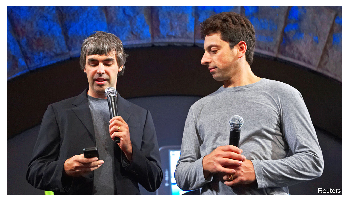

In [7]:
image_path = 'S_L_image.jpg'
img = mpimg.imread(image_path)
plt.axis('off')
plt.imshow(img)

Removing background from S_L_image.jpg please wait...
Background removed from Image and saved to output/S_L_image.png


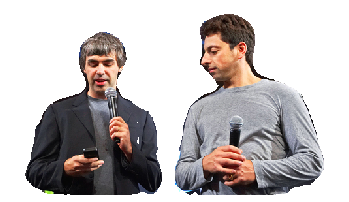

In [8]:
remover(image_path, 'S_L_image')